In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
from IPython import display

In [2]:
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.cifar10.load_data()

In [3]:
data = tf.data.Dataset.from_tensor_slices(xtrain)

In [4]:
def preprocess(image):
    return image/255

In [5]:
data

<_TensorSliceDataset element_spec=TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None)>

In [6]:
data = data.map(preprocess).shuffle(len(xtrain)).cache().prefetch(len(xtrain)).batch(128)

In [7]:
data

<_BatchDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None)>

In [8]:
def generator_model():
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(4*4*256, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((4,4,256)))
    assert model.output_shape == (None, 4, 4, 256)
    
    model.add(tf.keras.layers.Conv2DTranspose(128, kernel_size=(5,5), strides=(1,1), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    assert model.output_shape == (None, 4, 4, 128)
    
    
    model.add(tf.keras.layers.Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    assert model.output_shape == (None, 8, 8, 64)
    
    model.add(tf.keras.layers.Conv2DTranspose(32, kernel_size=(5,5), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    assert model.output_shape == (None, 16, 16, 32)
    
    model.add(tf.keras.layers.Conv2DTranspose(3, kernel_size=(5,5), strides=(2,2), padding='same', activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

generator = generator_model()

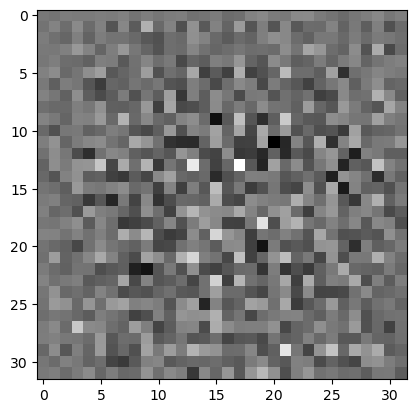

In [9]:
generated_image = generator(tf.random.normal([1, 100]))
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [10]:
def discriminator_model():
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(5,5), strides=(2,2), input_shape=[32, 32, 3]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(16, kernel_size=(5,5), strides=(2,2)))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [11]:
discriminator = discriminator_model()
discriminate_image = discriminator(generated_image)
print(discriminate_image)

tf.Tensor([[0.00487954]], shape=(1, 1), dtype=float32)


In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [13]:
def discriminator_loss(real_data, fake_data):
    real_discriminator_loss = cross_entropy(tf.ones_like(real_data), real_data)
    fake_discriminator_loss = cross_entropy(tf.zeros_like(fake_data), fake_data)
    total_loss = real_discriminator_loss + fake_discriminator_loss
    return total_loss

In [14]:
def generator_loss(fake_data):
    return cross_entropy(tf.ones_like(fake_data), fake_data)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
EPOCHS = 50
noise_dim = 100
num_images_to_generate = 16
BATCH_SIZE = 128

In [17]:
@tf.function

def train_step(real_image):
    
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        generated_image = generator(noise, training=True)
        
        disc_real_output = discriminator(real_image, training=True)
        disc_fake_output = discriminator(generated_image, training=True)
        
        gen_loss = generator_loss(disc_fake_output)
        disc_loss = discriminator_loss(disc_real_output, disc_fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    

In [18]:
def generate_and_save_images(model, epochs, input_data):
    generated_image = model(input_data, training=True)
    
    for i in range(generated_image.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_image[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig("Image at epoch {}.png".format(epochs))
    plt.show()

In [19]:
seed = tf.random.normal([num_images_to_generate, noise_dim])

def train(dataset, epochs):
    
    for epoch in range(epochs):
        
        start = time.time()
        
        for batch_image in dataset:
            
            train_step(batch_image)
            
            
        generate_and_save_images(generator, epoch+1, seed)
        
        print("Time for epoch {} is {} seconds.".format(epoch+1, time.time() - start))
        
    generate_and_save_images(generator, epoch, seed)

In [20]:
train(data, 20)

KeyboardInterrupt: 